<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L35-LinkPredictionGraphAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link Prediction With Graph Autoencoder

Link here, more info about ["Variational Graph Auto-Encoders"](https://arxiv.org/pdf/1611.07308.pdf)

## Motivation and Importance of Link Prediction in Geometric Deep Learning

In the age of information and connectivity, graph data representation and analysis have become crucial in a wide range of applications, from social networks and recommendation systems to biology, transportation, and cybersecurity. In this context, the task of "link prediction" plays a pivotal role, and it is a fundamental component of the emerging field of "Geometric Deep Learning."

In the context of Geometric Deep Learning, link prediction benefits from deep graph models that can learn rich and meaningful representations of nodes and relationships. These models leverage the geometric and topological structure of graphs to make accurate predictions. The importance of link prediction lies in its ability to enhance decision-making, operational efficiency, and understanding of relationships in complex systems.

The motivation behind link prediction in graphs is multi-faceted and fundamental:

1. **Understanding Network Topology:** In many real systems, network structure evolves over time. Predicting new links or relationships between nodes allows us to understand how the network topology evolves, which is crucial in fields like social networks (friendships), biology (protein-protein interactions), and technology (connections in the Internet of Things).

2. **Personalized Recommendations:** Link prediction is used in recommendation systems to identify potential connections a user might find valuable. This is especially useful in e-commerce and social networks, where user retention and satisfaction are essential.

3. **Anomaly Detection:** Identifying unexpected or anomalous relationships between nodes in a graph can be critical in fraud detection, cybersecurity, and epidemiology. Link prediction can help uncover unusual or potentially dangerous patterns.

4. **Resource Optimization:** In applications like logistics and transportation, link prediction is used to optimize routes and connections, minimizing costs and delivery times.

5. **Knowledge Discovery:** By predicting links, we can discover underlying connections that are not apparent at first glance. This can lead to the discovery of new knowledge and relationships in various fields.

## Link Prediction and Label Prediction
### Difference between them in the context of graph analysis and machine learning:

Link Prediction:

Definition: Link Prediction focuses on predicting the existence or probability of connections (links) between nodes in a graph. Its goal is to determine whether two nodes will be connected in the future or if an unobserved relationship exists in the graph.

Applications: Link Prediction is used in various applications, such as social networks to predict future friendships, recommendation systems to suggest new connections between users, and in biology to anticipate interactions between proteins, among others.

Label Prediction:

Definition: Label Prediction refers to the task of assigning labels (categories or attributes) to nodes in a graph. Instead of predicting links, it involves classifying or assigning labels to nodes based on features and relationships in the graph.

Applications: Label Prediction is used in many applications, such as classifying users in social networks based on their interests, classifying nodes in a transportation network according to their function (e.g., airports or train stations), or predicting gene function in a protein interaction network.

In summary, the main difference between Link Prediction and Label Prediction lies in their objective. Link Prediction focuses on predicting connections between nodes, while Label Prediction focuses on assigning labels or categories to nodes in a graph. Both tasks are important in graph analysis and have applications in various fields, but they involve different approaches and goals.

## Formally
Given an input graph $G$, and two nodes $u$ and $v$, predict if there is an edge between $u$ and $v$.

![autoencoder](https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/autoencoder.png)

Steps:

1. Input a graph.
2. (Encoder) one or more convolutional Graph Neural Network.
3. (Latent space) Produce the embedding of graph: $Z=\hat{X}$.
4. (Decoder) Reconstruct the input adjacency matrix, as inner product between latent variable Z.

## Difference with Node Embedding (GAE model)

> _Loss function is the key difference in Graph Autoencoder (GAE)_

#### GAE for node embedding
Binary cross entropy loss

$$
ℒ(x,y) = L = \{l_1,...l_n\}^T
$$

$$
l_n = -W_n[y_n \cdot log(x_n) + (1 - y_n) \cdot (1 - log(x_n))]
$$

#### GAE for link prediction
Binary cross entropy with logits loss

$$
ℒ(x,y) = L = \{l_1,...l_n\}^T
$$

$$
l_n = -W_n[y_n \cdot log \space σ(x_n) + (1 - y_n) \cdot log(1 - \space σ(x_n))]
$$
Where, $σ$ is sigmoid function.





In [1]:
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install pyg_lib --no-index -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 16.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 38.9 MB/s eta 0:00:00


In [2]:
import torch
# !pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import pandas as pd

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

# GAE for link prediction

[The Cora dataset](https://ojs.aaai.org/aimagazine/index.php/aimagazine/article/view/2157) introduced by Sen et al. in 2008, Cora (no license) is the most popular dataset for node classification in the scientific literature. It represents a network of 2,708 publications, where each connection is a reference. Each publication is described as a binary vector of 1,433 unique words, where 0 and 1 indicate the absence or presence of the corresponding word, respectively. This representation is also called a binary bag of words in natural language processing. Our goal is to classify each node into one of seven categories.

Regardless of the type of data, visualization is always an important step to getting a good grasp of the problem we face. However, graphs can quickly become too big to visualize using Python libraries such as networkx. This is why dedicated tools have been developed specifically for graph data visualization. We utilize two of the most popular ones: yEd Live (https://www.yworks.com/yed-live/) and Gephi (https://gephi.org/).

The following figure is a plot of the Cora dataset made with yEd Live. You can see nodes corresponding to papers in orange and connections between them in green. Some papers are so interconnected that they form clusters. These clusters should be easier to classify than poorly connected nodes. You can check  the [original code from PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)

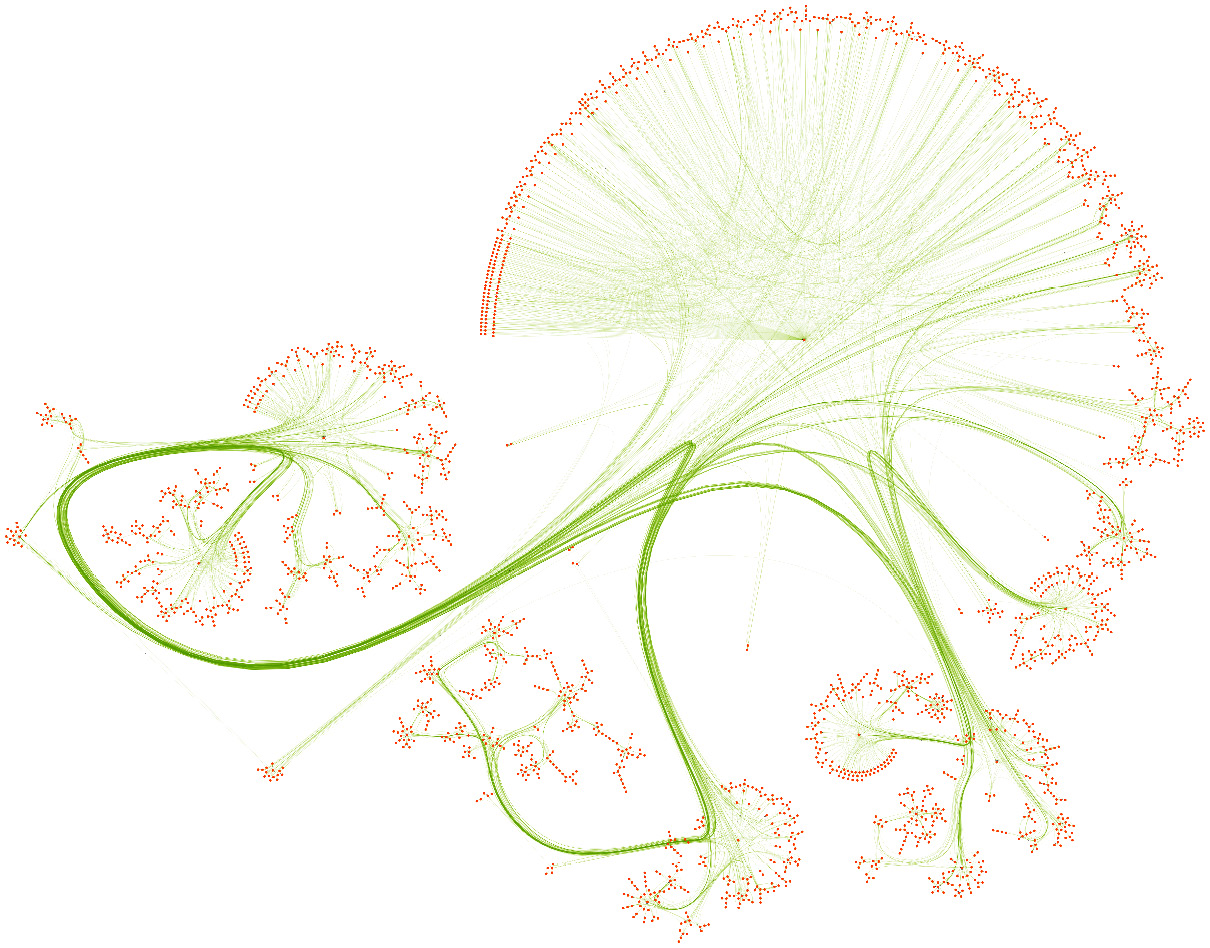

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

In [5]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures()) # Row-normalize the attributes given in `attrs`.
data = dataset[0]
print(dataset.data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [6]:
data.train_mask, data.y # this isn't our interest variable

(tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([3, 4, 4,  ..., 3, 3, 3]))

In [7]:
# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [8]:
# Check out train positive mask
pd.DataFrame(data.train_pos_edge_index.numpy().T, columns=['start_node', 'end_node'])

,start_node,end_node
0,0,633
1,0,1862
2,0,2582
3,1,2
4,1,652
...,...,...
8971,2706,2707
8972,2707,165
8973,2707,598
8974,2707,1473


In [9]:
# Check out train negative adjacency matix mask
pd.DataFrame(data.train_neg_adj_mask.numpy().T, columns=[f'node_{node}' for node in range(data.num_nodes)], index=[f'node_{node}' for node in range(data.num_nodes)])

,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,...,node_2698,node_2699,node_2700,node_2701,node_2702,node_2703,node_2704,node_2705,node_2706,node_2707
node_0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_3,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_4,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_2703,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,False,False,False,False,False
node_2704,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,False,False,False
node_2705,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,False,False,False
node_2706,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False


In [10]:
len(data.x[0]) # vocabulary \\ features nodes \\ attributes nodes

1433

In [11]:
len(data.x) # Nodes number

2708

In [12]:
data.num_nodes

2708

#### Simple autoencoder model

check graph convolutional operator documentarion in PyTorch Geometrics: [`GCNConv()`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html). Also, check paper [“Semi-supervised Classification with Graph Convolutional Networks”](https://arxiv.org/pdf/1609.02907.pdf) 22 Feb 2017.

This time we build our own [`recon_loss()`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAE.html#torch_geometric.nn.models.GAE.recon_loss) and given latent variables $z$, computes the binary cross entropy loss for positive edges `pos_edge_index` and negative sampled edges from the GAE in PyTorch Geometric

In [13]:
class SimpleGraphAutoencoder(torch.nn.Module):
    def __init__(self):
        super(SimpleGraphAutoencoder, self).__init__()
        self.conv1 = GCNConv(in_channels=dataset.num_features, out_channels=128)
        self.conv2 = GCNConv(in_channels=128, out_channels=64)

    def encode(self):
        x = self.conv1(x=data.x, edge_index=data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x=x, edge_index=data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list

In [14]:
model, data = SimpleGraphAutoencoder().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

Now, build a method to create a Tensor with ones or zeros with `pos_edge_index`...

In [15]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [16]:
def train():
    model.train()

    neg_edge_index = negative_sampling( # Extract negative edge index
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward() # computes gradients
    optimizer.step() # update weightses

    return loss

In [17]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid

        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link

        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [18]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.6878, Val: 0.8287, Test: 0.7418
Epoch: 020, Loss: 0.6322, Val: 0.8287, Test: 0.7418
Epoch: 030, Loss: 0.5485, Val: 0.8287, Test: 0.7418
Epoch: 040, Loss: 0.5164, Val: 0.8383, Test: 0.8142
Epoch: 050, Loss: 0.4879, Val: 0.8710, Test: 0.8465
Epoch: 060, Loss: 0.4693, Val: 0.8886, Test: 0.8538
Epoch: 070, Loss: 0.4688, Val: 0.8934, Test: 0.8651
Epoch: 080, Loss: 0.4529, Val: 0.9046, Test: 0.8770
Epoch: 090, Loss: 0.4496, Val: 0.9108, Test: 0.8822
Epoch: 100, Loss: 0.4438, Val: 0.9119, Test: 0.8866


In [19]:
z = model.encode()
predict_edge_index = model.decode_all(z)

In [20]:
predict_edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    1,    2,  ..., 2705, 2706, 2707]], device='cuda:0')

In [21]:
predict_edge_index = pd.DataFrame(predict_edge_index.cpu().numpy().T, columns=['start_node', 'end_node'])

Now! try to plot the links..

In [22]:
predict_edge_index.head()

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,4
4,0,5


In [23]:
# plot links ...
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(predict_edge_index, "start_node", "end_node")

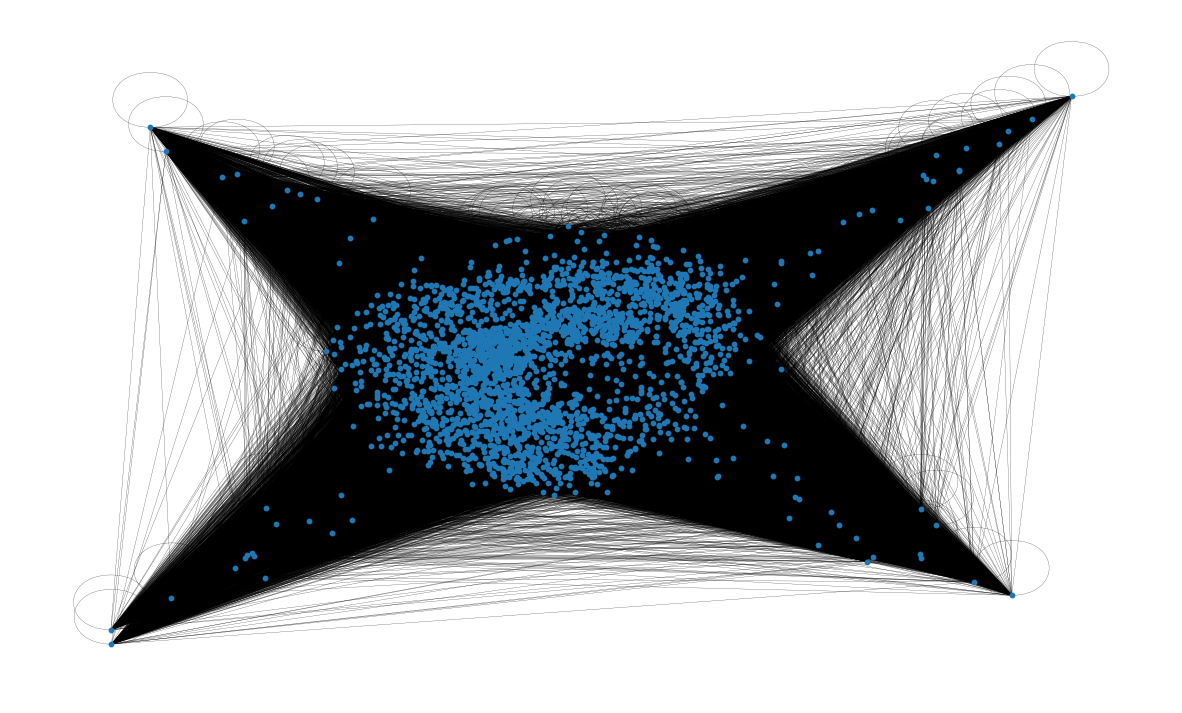

In [24]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=10, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)